# Kaggle MNIST Digit Recognizer Competition Notebook

## 1. Loading Tabular Data And Packages

The datasets for training and test data are loaded as files `train.csv` and `test.csv` as downloaded from the Kaggle competition, which can be accessed [here](https://www.kaggle.com/c/digit-recognizer).

In [25]:
#First load up any packages that will be needed
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from pathlib import Path
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier

In [2]:
#Load training and test data into separate dataframes
pwd = os.getcwd()
root = Path('input', 'mnist')
file = 'train.csv'
df_train = pd.read_csv(root / file)
file = 'test.csv'
df_test = pd.read_csv(root / file)

#Examine dataframe to see ensure data is loaded correctly
df_train.head()
#df_test.head()

df_combined = pd.concat([df_train, df_test])

Due to the ability to use domain knowledge of the datset, the dataset is comprised of a label that describes the digit and a 28 x 28 matrix of integers to describe the lightness or darkness of the pixel at each position in the matrix, with lower values representing lighter pixels and higher values representing darker pixels. The values range from 0 to 255, inclusive.

As the pixels themselves will not give much information without performing transformations on the dataset, the only data of use that can be plotted is of the `label` column in the training data.

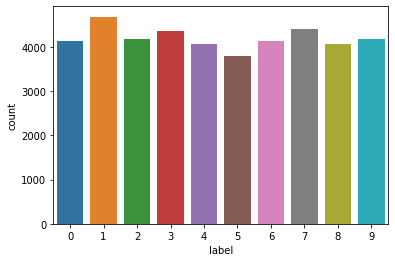

In [3]:
sns.countplot(x=df_train['label']);

The plot shows that all values of `label` are roughly equally distributed. The next step is to ensure the dataset is useable as is, and to check for missing and duplicate values, as well as to look at the size of both datasets.

In [4]:
#Get number of rows and columns of data in the training dataset
print(df_train.shape)
#Get number of non-null entries in each column, as well as the datatype of each column
df_train.info()
#Get information on data contained in each column including number of unique entries, mean, standard deviation, minimum and maximum values and median value
df_train.describe(include='all')

(42000, 785)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [5]:
#Get number of rows and columns of data in the testing dataset
print(df_test.shape)
#Get number of non-null entries in each column, as well as the datatype of each column
df_test.info()
#Get information on data contained in each column including number of unique entries, mean, standard deviation, minimum and maximum values and median value
df_test.describe(include='all')

(28000, 784)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,28000.0,...,28000.000000,28000.000000,28000.000000,28000.000000,28000.000000,28000.0,28000.0,28000.0,28000.0,28000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.164607,0.073214,0.028036,0.011250,0.006536,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.473293,3.616811,1.813602,1.205211,0.807475,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,254.000000,193.000000,187.000000,119.000000,0.0,0.0,0.0,0.0,0.0


In [6]:
#Check for missing/null/NaN entries in both datasets
print("Missing entries in training set: ", df_train.isnull().any().sum())
print("Missing entries in testing set: ", df_test.isnull().any().sum())
#Check for duplicated entries in both datasets
print("Number of duplicated entries in training set: ", len(df_train[df_train.duplicated(keep=False)].index))
print("Number of duplicated entries in training set: ", len(df_train[df_train.duplicated(keep=False)].index))

Missing entries in training set:  0
Missing entries in testing set:  0
Number of duplicated entries in training set:  0
Number of duplicated entries in training set:  0


There appears to be no null data and no duplicate entries in either dataset. The training data appears to have 42,000 entries and the testing data appears to have 28,000 entries for a 60/40 split. Next, transformations can be performed on the data to ensure it is easier for the convolutional neural network or CNN.

The first transformation performed is to normalize the data, to change the data from an integer value between 0 and 255 to a float value between 0 and 1 which will allow the CNN to converge faster.

In [9]:
#Get list of pixel column names
col_names = list(df_train.columns[1:])
#Copy created so code can be re-run without reimporting from csv
df_train_normalize = df_train.copy()
df_test_normalize = df_test.copy()
df_train_normalize[col_names] = df_train_normalize[col_names].apply(lambda r: r / 255.0)
df_test_normalize[col_names] = df_test_normalize[col_names].apply(lambda r: r / 255.0)

In [10]:
#Separate dependent/independent variables
y_train = df_train_normalize.filter(['label'], axis=1)
X_train = df_train_normalize.drop(['label'], axis=1)
X_test = df_test_normalize.copy()
#Free up resources
del df_test_normalize

Next, the 1x784 1D array will be converted to a 28x28x1 3D array. The extra channel is for the RGB values but as the data is greyscale, only the 1 extra dimension is required.

In [11]:
#Reshape dataframe from 1x784 to 28x28x1
X_train = X_train.values.reshape(42000,28,28,1)
X_test = X_test.values.reshape(28000,28,28,1)

The final transformation to be performed is on the 'Y' data, or the digit labels. The data will be converted from a single numerical column containing the digit in the data into ten binary categorical columns through the use of one-hot encoding. Each of the columns of the new data represents the possibility that the data represents the digit in the column. For example, a `1` digit will be represented as $[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]$. This represents 100% certainty that the digit being displayed is a `1` as it is labelled training data. The predicted output data will represent a set of probabilities for each digit to give a probability distribution. The digit with the highest probability will be the label assigned to the predicted data.

In [12]:
#One hot encode
y_train = to_categorical(y_train, num_classes = 10)

Next, some of the samples can be examined. Here, the first twenty examples are plotted shown.

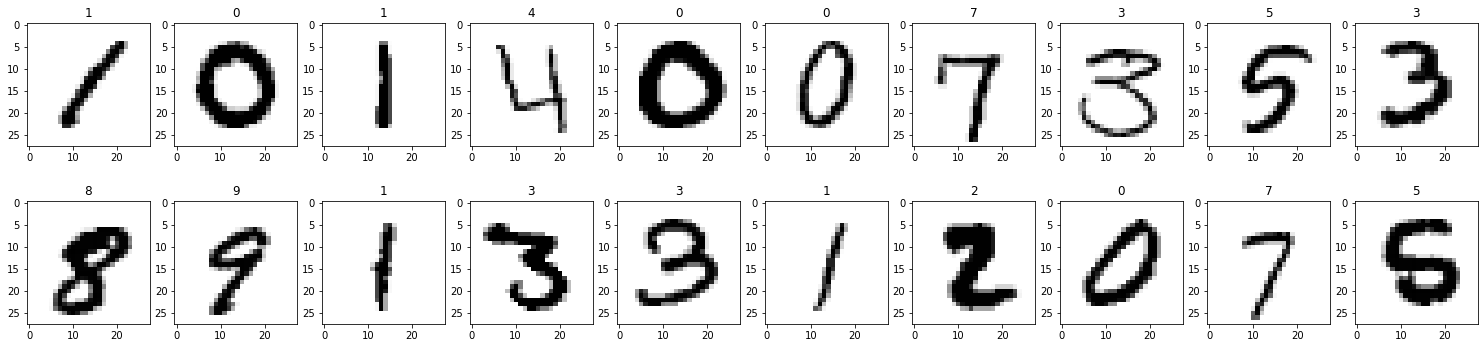

In [13]:
#Plot first 20 samples
plt.figure(figsize=(26, 6))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i], cmap='binary')
    plt.title(np.argmax(y_train[i]))

Performing data augmentation on the dataset to generate batches of tensor image data for the model to prevent overfitting to the training data. This should improve the accuracy of the model.

In [37]:
datagen = ImageDataGenerator(
    rotation_range=10, #Rotate images randomly by 10 degrees
    width_shift_range=0.1, #Horizontally shift images randomly by 10%
    height_shift_range=0.1, #Vertically shift images randomly by 10%
    zoom_range=0.1, #Zoom images randomly by 10%
    fill_mode='nearest', #Fill missing pixels with nearest pixel values
)
datagen.fit(X_train)

A validation dataset will be created to have three datasets: training, validation, and testing. The training set will be used to train the model and set the weights of the layers. The testing set will be used to predict to generate labels to submit and compare to the entries in the competition. The validation set will be used to generate scoring metrics and to evaluate the model and tune hyperparameters.

In [15]:
#Create validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

# 2. Model Building

The model created is a CNN using keras sequential, which allows for layers to be added to the model.

In [41]:
#Create scikeras wrapper for model
def get_model():
    optimizer = Adadelta(learning_rate=1.4, rho=0.9, epsilon=1e-07)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=5, activation='relu', padding = 'Same', input_shape=(28,28,1)))
    model.add(Conv2D(32, kernel_size=5, activation='relu', padding = 'Same'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(Conv2D(64, kernel_size=3, activation='relu', padding = 'Same'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(units=256,activation="relu"))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
#Print summary of model with layers
get_model().summary()

Model: "sequential_387"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1548 (Conv2D)        (None, 28, 28, 32)        832       
                                                                 
 conv2d_1549 (Conv2D)        (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_774 (MaxPooli  (None, 14, 14, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_1550 (Conv2D)        (None, 14, 14, 64)        18496     
                                                                 
 conv2d_1551 (Conv2D)        (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_775 (MaxPooli  (None, 7, 7, 64)         0         
 ng2D)                                              

After performing multiple runs and averaging the accuracy scores, Adadelta was determined to be the best optimizer choice for this model as it consistently was top 3 in performance, along with RMSprop and Adam. In the end, Adadelta was chosen as the optimizer. Then, grid search is performed to find the optimal hyperparameters of the optimizer, learning rate and rho.

In [40]:
model = KerasClassifier(model=get_model, learning_rate=0.001, rho=0.95, verbose=0)
#learning_rate = [0.001, 0.01, 0.1, 1, 10] #Refine learning rate
#learning_rate = [1, 3, 5, 7, 9] #Further refine learning rate
learning_rate = [1, 1.2, 1.4, 1.6, 1.8]
rho = [0.8, 0.85, 0.90, 0.95, 0.99]
param_grid = dict(learning_rate=learning_rate, rho=rho)

#Perform grid search over small sample to find optimal hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_val, y_val) #Use validation set to reduce training time

#Print results of grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.925476 using {'learning_rate': 1.4, 'rho': 0.9}
0.892619 (0.009920) with: {'learning_rate': 1, 'rho': 0.8}
0.896667 (0.029723) with: {'learning_rate': 1, 'rho': 0.85}
0.865000 (0.082999) with: {'learning_rate': 1, 'rho': 0.9}
0.889524 (0.017509) with: {'learning_rate': 1, 'rho': 0.95}
0.788810 (0.068453) with: {'learning_rate': 1, 'rho': 0.99}
0.899048 (0.031844) with: {'learning_rate': 1.2, 'rho': 0.8}
0.915238 (0.019952) with: {'learning_rate': 1.2, 'rho': 0.85}
0.901429 (0.007308) with: {'learning_rate': 1.2, 'rho': 0.9}
0.890952 (0.019875) with: {'learning_rate': 1.2, 'rho': 0.95}
0.823810 (0.069792) with: {'learning_rate': 1.2, 'rho': 0.99}
0.894524 (0.006236) with: {'learning_rate': 1.4, 'rho': 0.8}
0.904286 (0.015130) with: {'learning_rate': 1.4, 'rho': 0.85}
0.925476 (0.005292) with: {'learning_rate': 1.4, 'rho': 0.9}
0.896429 (0.020429) with: {'learning_rate': 1.4, 'rho': 0.95}
0.852143 (0.046832) with: {'learning_rate': 1.4, 'rho': 0.99}
0.895000 (0.025422) with: {'le

In [42]:
model = KerasClassifier(model=get_model, verbose=0)
#batch_size = [20, 40, 60, 80, 100] #Refine batch size
#batch_size = [10, 15, 20, 25, 30, 35, 40] #Further refine batch size
batch_size = [25, 27, 29, 31, 33, 35]
epochs = [1]
param_grid = dict(batch_size=batch_size, epochs=epochs)

#Perform grid search over small sample to find optimal hyperparameters
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_val, y_val) #Use validation set to reduce training time

#Print results of grid search
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.931429 using {'batch_size': 25, 'epochs': 1}
0.931429 (0.000000) with: {'batch_size': 25, 'epochs': 1}
0.908810 (0.005664) with: {'batch_size': 27, 'epochs': 1}
0.914524 (0.018186) with: {'batch_size': 29, 'epochs': 1}
0.912381 (0.027456) with: {'batch_size': 31, 'epochs': 1}
0.918810 (0.006633) with: {'batch_size': 33, 'epochs': 1}
0.883810 (0.055886) with: {'batch_size': 35, 'epochs': 1}


Epoch 1/10
1303/1303 - 83s - loss: 0.3038 - accuracy: 0.9008 - val_loss: 0.0702 - val_accuracy: 0.9817 - 83s/epoch - 64ms/step
Epoch 2/10
1303/1303 - 87s - loss: 0.0995 - accuracy: 0.9704 - val_loss: 0.0424 - val_accuracy: 0.9881 - 87s/epoch - 67ms/step
Epoch 3/10
1303/1303 - 84s - loss: 0.0737 - accuracy: 0.9780 - val_loss: 0.0536 - val_accuracy: 0.9881 - 84s/epoch - 65ms/step
Epoch 4/10
1303/1303 - 84s - loss: 0.0658 - accuracy: 0.9805 - val_loss: 0.0336 - val_accuracy: 0.9905 - 84s/epoch - 65ms/step
Epoch 5/10
1303/1303 - 86s - loss: 0.0557 - accuracy: 0.9829 - val_loss: 0.0314 - val_accuracy: 0.9933 - 86s/epoch - 66ms/step
Epoch 6/10
1303/1303 - 85s - loss: 0.0548 - accuracy: 0.9851 - val_loss: 0.0319 - val_accuracy: 0.9912 - 85s/epoch - 65ms/step
Epoch 7/10
1303/1303 - 86s - loss: 0.0478 - accuracy: 0.9859 - val_loss: 0.0308 - val_accuracy: 0.9929 - 86s/epoch - 66ms/step
Epoch 8/10
1303/1303 - 87s - loss: 0.0442 - accuracy: 0.9879 - val_loss: 0.0433 - val_accuracy: 0.9912 - 87s/ep

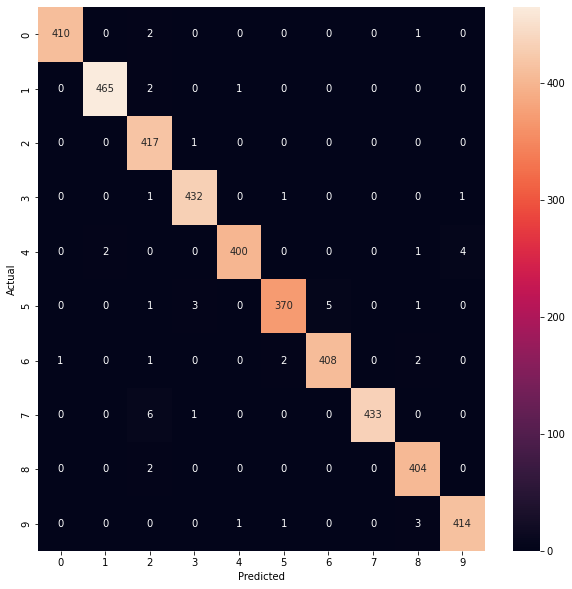

In [43]:
model = get_model()
batch_size = 29
epochs = 10
#model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2) #Fit model without data augmentation
model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs, validation_data=(X_val,y_val), verbose=0)
predictions = model.predict(X_val)
y_pred = np.argmax(predictions, axis=-1)
y_true = np.argmax(y_val, axis=-1)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='g');
plt.xlabel('Predicted');
plt.ylabel('Actual');

Just to confirm, the samples used for the predictions can be shown along with the predicted label.

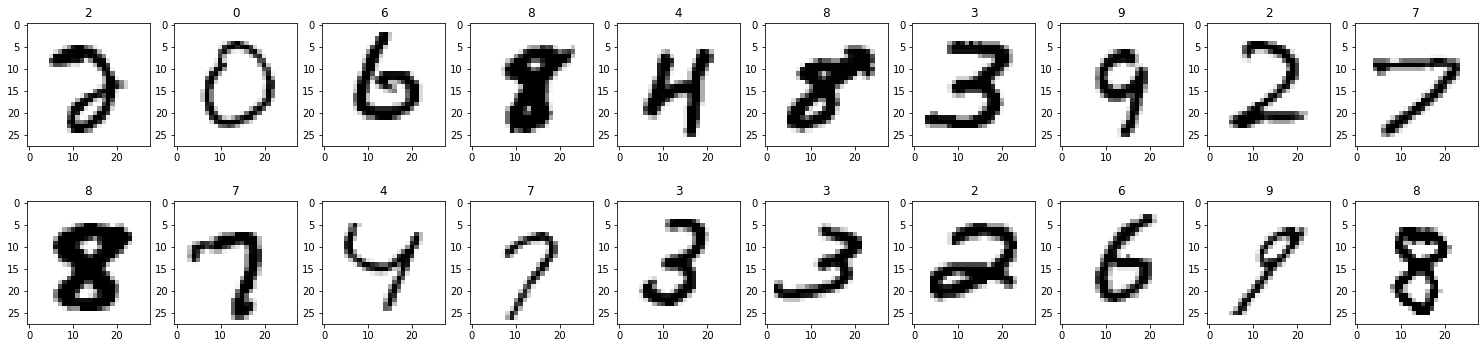

In [44]:
#Plot first 20 samples
plt.figure(figsize=(26, 6))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_val[i], cmap='binary')
    plt.title(np.argmax(y_val[i]))

The final step is to create the submission file.

In [47]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=-1)
outputLabels = pd.Series(y_pred, name='Label')
outputIds = pd.Series(range(1,28001), name='ImageId')
df_submit = pd.concat([outputLabels, outputIds], axis=1)
os.makedirs('output/mnist', exist_ok=True)
df_submit.to_csv('output/mnist/out.csv', index=False)

This resulted in a score of 0.98964.